In [2]:
%load_ext autoreload
%autoreload 2
import sys,os,importlib,gc,string
import xarray as xr
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm

os.chdir('/home/peterp/projects/tc_emulator/results')

sys.path.append('../git_tc_emulator')
import _weather_pattern_class; importlib.reload(_weather_pattern_class)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module '_weather_pattern_class' from '/home/peterp/projects/tc_emulator/git_tc_emulator/_weather_pattern_class.py'>

In [5]:
year = 2024

In [6]:
atl = _weather_pattern_class.weather_patterns(source='ERA5_%s' %(year), working_directory='./')

In [7]:
# load MSLP and VWS
# these fields were preprocessed using the scripts in input_data_preparation
vwsOld = xr.load_dataset('/home/peter/Projects/data/ERA5/ERA5_vws_atl_1x1_daily_rmTC.nc')['vws'].loc['1982':'2020']
vwsNew = xr.load_dataset('/home/peter/Projects/data/ERA5/ERA5_vws_atl_1x1_daily_rmTC_%s.nc' %(year))['vws']
vws = xr.concat((vwsOld,vwsNew), dim='time')

FileNotFoundError: [Errno 2] No such file or directory: '/home/peter/Projects/data/ERA5/ERA5_vws_atl_1x1_daily_rmTC.nc'

In [5]:
# load MSLP and VWS
# these fields were preprocessed using the scripts in input_data_preparation
mslOld = xr.load_dataset('/home/peter/Projects/data/ERA5/ERA5_MSLP_atl_1x1_daily_rmTC.nc')['MSLP'].loc['1982':'2020']
mslNew = xr.load_dataset('/home/peter/Projects/data/ERA5/ERA5_MSLP_atl_1x1_daily_rmTC_%s.nc' %(year))['MSLP']
msl = xr.concat((mslOld,mslNew), dim='time')

In [6]:
atl.add_data(vws, 'VWS', 'PRGn_r')
atl.add_data(msl, 'MSLP', 'RdBu_r')

In [7]:
atl.preprocess_select_months(months=[8,9,10], month_colors=['#bfef45','#ffe119','#f58231'])
atl.preprocess_standardized_anomalies(['1982','2011'])
atl.preprocess_regrid(reference_lats=np.arange(10, 30, 2.5),reference_lons=np.arange(-90, -10, 2.5))
atl.preprocess_create_vector(variables = ['VWS','MSLP'])
atl.store_input('ERA5_VWS-MSLP_noTC3')

/home/peter/miniconda3/envs/py_main/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/peter/miniconda3/envs/py_main/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [8]:
atl.load_input('ERA5_VWS-MSLP_noTC3')
years = np.array([year])
atl.set_split(years=years)

In [9]:
atl.mapping_raw()
atl.load_mapping('mapping_raw')

1

In [10]:
nrows,ncols=5,4
emulator_path = '/home/peter/Projects/tc_emulator/results/ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1/'
tag = 'SOM_pcaInit%sx%s_v1_1982-2020' %(nrows,ncols)
atl.add_external_cluster_centers(tag, emulator_path)

In [11]:
atl.assign_data_to_clusters()

In [12]:
atl.define_plot_environment(pre_mapping='mapping_raw', clustering=tag, post_mapping=None, nrows=nrows, ncols=ncols)
atl.stats_TC(file='tracks/tracks_ibtracks.csv', overwrite=True)


{'SOM': <minisom.MiniSom object at 0x7f712d83b1c0>}
.//ERA5_VWS-MSLP_noTC3/mapping_raw_2022-2022/SOM_pcaInit5x4_v1_1982-2020/grid_5x4


In [13]:
atl.stats_frequency()

/home/peter/miniconda3/envs/py_main/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/peter/miniconda3/envs/py_main/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/peter/miniconda3/envs/py_main/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/peter/miniconda3/envs/py_main/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/peter/miniconda3/envs/py_main/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r 

In [14]:
atl.plot_freq()


## Counterfactuals

In [15]:
train_folder = emulator_path + 'mapping_sammon_1982-2020/grid_5x4/emulator/2011-2020/'

In [16]:
# HadISST
sst_hist = xr.open_dataset('/home/peter/Projects/data/SST/HadISST_sst.nc')['sst'].loc[:,20:10,-90:-20]
lat_weight = np.cos(np.deg2rad(sst_hist.latitude.values))
lat_weight_array = np.repeat(lat_weight[np.newaxis,:], sst_hist.shape[2], 0).T
valid = np.isfinite(sst_hist[0,:,:].values)
sst_hist = xr.DataArray(np.nansum(sst_hist * lat_weight_array, axis=(1,2)) / np.sum(lat_weight_array[valid]), coords={'time':sst_hist.time}, dims=['time'])
hadisst_MDR = sst_hist[np.isin(sst_hist.time.dt.month,[8,9,10])].groupby('time.year').mean('time').loc[:2020]


# yearly SSTS for OISST
tmp = xr.load_dataset('/home/peter/Projects/data/SST/OISST_sst_MDR_daily_all.nc')['sst']
oisst_MDR = tmp.loc[np.isin(tmp.time.dt.month,[8,9,10])].groupby('time.year').mean('time')

(26.0, 29.0)

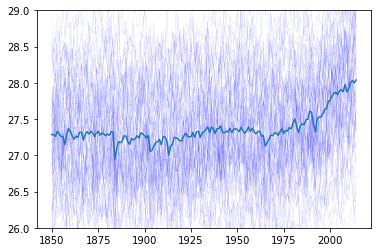

In [17]:
# CMIP6
%matplotlib inline
sst_cmip6 = xr.open_dataset('/home/peter/Projects/tc_emulator/results/SST_MDR_ASO_CMIP6.nc')['sst']
cmip6_MDR = sst_cmip6.mean('model').compute()

for mod in sst_cmip6.model.values:
    plt.plot(sst_cmip6.year, sst_cmip6.loc[mod,:], color='b', alpha=0.2, linewidth=0.3)
plt.plot(sst_cmip6.year,cmip6_MDR, label='CMIP6 median')   
plt.ylim(26,29)

In [18]:
lr_cmip6 = sm.OLS(cmip6_MDR.loc[1982:].values, sm.add_constant(sst_cmip6.loc[:,1982:].year.values)).fit().params
lr_hadisst = sm.OLS(hadisst_MDR.loc[1982:].values, sm.add_constant(hadisst_MDR.loc[1982:].year.values)).fit().params
lr_oisst = sm.OLS(oisst_MDR.loc[1982:].values, sm.add_constant(oisst_MDR.loc[1982:].year.values)).fit().params

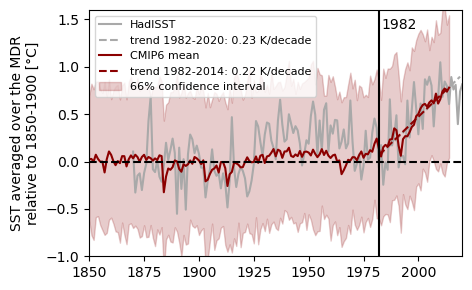

In [19]:
plt.close()
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3), dpi=100)
bounds = np.nanpercentile((sst_cmip6 - cmip6_MDR.loc[1850:1900].mean()).rolling(year=1, center=True).mean(),[17,83],axis=0).squeeze()
ax.fill_between(sst_cmip6.year, bounds[0,:], bounds[1,:], 
                 alpha=0.2, color='darkred', label='66% confidence interval', zorder=0)

for sst_raw,lr,color,label in zip([cmip6_MDR,hadisst_MDR][::-1],[lr_cmip6,lr_hadisst][::-1],
                              ['darkred','darkgray'][::-1],['CMIP6 mean','HadISST'][::-1]):
    
    shift = sst_raw.loc[1850:1900].mean().values
    sst = sst_raw - shift
    
    ax.plot(sst.year,sst,color=color, label=label,zorder=1)
    
    ax.plot(range(1982,sst.year.values[-1]), lr[0] - shift + lr[1] * range(1982,sst.year.values[-1]), color=color, linestyle='--',
             label='trend 1982-%s: %s K/decade' %(sst.year.values[-1],round(lr[1]*10,2)),zorder=1)
    # ax.plot([1982],[lr[0] + lr[1]*1982], marker='*', markerfacecolor=color, markeredgecolor='k', markersize=15,
    #              label='trend in 1982: %s K' %(np.round(lr[0] + lr[1]*1982,2)), linestyle='', zorder=10)

ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=1982, color='k')
ax.annotate('1982', xy=(1983,1.4))
ax.set_ylabel('SST averaged over the MDR\nrelative to 1850-1900 [°C]')
ax.set_ylim(-1,1.6)
ax.legend(loc='upper left', fontsize=8)
ax.set_xlim(1850,2020)
plt.tight_layout()

In [20]:
detrend = oisst_MDR - (lr_cmip6[1] * oisst_MDR.year + lr_cmip6[0])
lr_detrend = sm.OLS(detrend.loc[1982:2020].values, sm.add_constant(detrend.loc[1982:2020].year.values)).fit().params

sst_counterfacts = {'ref':oisst_MDR}
cou = detrend + lr_cmip6[0] + lr_cmip6[1] * 1982
sst_counterfacts['1982'] = cou
cou = detrend + lr_cmip6[0] + lr_cmip6[1] * 2022
sst_counterfacts['2022'] = cou

In [21]:
# choose components
alphabet = iter(list(string.ascii_lowercase))
dt = {'g':'gWeaLag2Weight', 'sL':'sLWeaNeigh', 'wS':'wS100nnQrSST', 'Emu':'Emu0', 'name':'main','l':next(alphabet),'c':'c'}
N = 1000
years = range(1982,2021)
overwrite = False

tag = '_'.join([dt[k] for k in ['g','sL','wS','Emu']])
print(tag)
import _emulator; importlib.reload(_emulator); from _emulator import *
for k,v in {k:v for k,v in dt.items() if k in ['g','sL','wS','Emu']}.items():
    exec("import %s; importlib.reload(%s); from %s import *" % tuple(['components.'+k+'.'+v]*3))
genesis_obj = pickle.load(open(train_folder+'/_comp_g_'+dt['g']+'/genesis_obj.pkl', 'rb'))
end_obj = pickle.load(open(train_folder+'/_comp_sL_'+dt['sL']+'/end_obj.pkl', 'rb'))
wind_obj = pickle.load(open(train_folder+'/_comp_wS_'+dt['wS']+'/wind_obj.pkl', 'rb'))
emu = storm_emulator(dir=train_folder, tag=tag, emulate_season_function=emulate_season_function)

gWeaLag2Weight_sLWeaNeigh_wS100nnQrSST_Emu0


In [22]:
years = np.array([year])
# get sst
sst_MDR = xr.load_dataset('/home/peter/Projects/data/SST/OISST_sst_MDR_daily_all.nc')['sst']
sst_MDR = sst_MDR[np.isin(sst_MDR.time.dt.year,years)]
sst_MDR = sst_MDR[np.isin(sst_MDR.time.dt.month,atl._months['mon'])]
sst_MDR = sst_MDR.assign_coords(time=np.array([str(d)[:10] for d in sst_MDR.time.values], np.datetime64))

# prepare gensis input
# this is a dataframe with an entry for each day
# this is required to get genesis probabilities
weather_sst = pd.DataFrame()
weather_sst['time'] =  np.array([str(d)[:10] for d in  atl._vector_time.values], np.datetime64)
weather_sst['year'] = atl._vector_time.dt.year
weather_sst['weather_0'] = atl._clust_labels
weather_sst['weather_1'] = np.roll(atl._clust_labels,1)
weather_sst['weather_2'] = np.roll(atl._clust_labels,2)
weather_sst['weather_3'] = np.roll(atl._clust_labels,3)
weather_sst = weather_sst.loc[np.isin(atl._vector_time.dt.year,years)]

weather_sst['sst'] = sst_MDR.sel(time=weather_sst.time.values)

weather_sst['day_in_season'] = 0
for year in np.unique(weather_sst.time.dt.year):
    tttmmmppp = weather_sst.loc[(weather_sst.time.dt.year==year),'day_in_season']
    weather_sst.loc[(weather_sst.time.dt.year==year),'day_in_season'] = np.arange(tttmmmppp.shape[0])

weather_sst = weather_sst.loc[(weather_sst.day_in_season>=3) & np.isin(weather_sst.year,years)]

emu._weather_sst = weather_sst

In [23]:
counterFacts = {}
for scenario in ['2022','1982']:
    if scenario == '1982' or True:
        sst_diff_counterfactual = (sst_counterfacts[scenario].loc[year] - sst_counterfacts['ref'].loc[year]).values    
    else:
        sst_diff_counterfactual = 0
    print(scenario,year,sst_diff_counterfactual)
    emu.simulate_sst_counterfactual(name='_%s_shift%s' %(year,scenario), years=[year], sst_shift=sst_diff_counterfactual, N=N, genesis_obj=genesis_obj, wind_obj=wind_obj, end_obj=end_obj, overwrite=overwrite)
    
    counterFacts['%s SST levels' %(scenario)] = emu._simu

2022 2022 0.0
1982 2022 -0.8999338456080039


In [41]:
counterFacts['%s SST levels' %('1982')].update({
    'color':'cyan', 'lsty':'--', 's':-0.0, 'label':"2022 at 1980's SST levels"})
counterFacts['%s SST levels' %('2022')].update({'color':'orange', 'lsty':'-', 's':0.3, 'label':'2022'})

indicator = 'ACE'
threshold = 95

year_groups = {
    2022 : {'years':[2022], 'color':'m', 'label':'2022', 'lsty':'-.', 'eva':0.4},
}

tmp = np.concatenate([d[indicator].values.flatten() for d in counterFacts.values()])
X = np.linspace(tmp.min(),tmp.max(),1000)
bw = (tmp.max() - tmp.min()) / 20

for scen_group in [[year], [year,1982]]:
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3), dpi=100)

    intersects = pd.DataFrame()
    for yrName,yrDT in year_groups.items():
        ys = []
        for scen in ['%s SST levels' %(yr) for yr in scen_group]:
            DT = counterFacts[scen]
            tmp = DT[indicator][np.isin(DT[indicator].year,yrDT['years'])].values.reshape(-1, 1)
            kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(tmp)
            log_dens = kde.score_samples(X.reshape(-1, 1))
            pdf = np.exp(log_dens)# / np.exp(log_dens).sum()
            cdf = np.cumsum(pdf)
            ax.plot(X, pdf, color=DT['color'], linestyle=DT['lsty'], zorder=10)
            ax.fill_between(X, pdf, color=DT['color'], linestyle=DT['lsty'], alpha=0.3, zorder=10)
            ys.append(pdf)

        #ax.fill_between(X, ys[0], ys[1], color=yrDT['color'], alpha=0.3, zorder=10)

    for scen in ['%s SST levels' %(yr) for yr in scen_group]:
        DT = counterFacts[scen]
        ax.plot([],[], DT['color'], linestyle=DT['lsty'], label=DT['label'])

    #for yrName,yrDT in year_groups.items():
    #    ax.plot([],[],color=DT['color'], label=yrDT['label'])

    ax.set_xlabel('Accumulated Cyclone Energy (ACE)')
    ax.set_xlim(0,400)
    ax.annotate('observed\nin 2022', xy=(178, 0.02), color='gray', va='center',fontsize=8, 
         xycoords='data',xytext=(220, 0.02), textcoords='data',
         arrowprops=dict(arrowstyle= '-|>',
                         color='gray',lw=1.5,ls='-'))
    ax2 = ax.twiny()
    ax2.set_xlim(0,400)

    for tr,lsty in zip([threshold,159.6],['-',':','--']):
        ax.axvline(x=tr, color='gray', linestyle=lsty)
        # ax.annotate(tr, xy=(tr, 0), rotation=90, ha='center', va='bottom', fontsize=8, backgroundcolor='w')

    ax2.set_xticks([95.1,159.6])
    ax2.set_xticklabels(['observed','extremely\nactive'], rotation=90, ha='center', fontsize=8)
    ax2.get_xticklabels()[1].set_color('gray')
    ax.legend(fontsize=7, loc='upper right')
    ax.set_ylabel('probability density')
    ax.set_ylim(0,0.01)

    plt.savefig('/home/peter/Documents/presentations/2022-12-06_allianz_TCs/figures/2022_hindcast_%s.png' %('-'.join([str(sc) for sc in scen_group])), 
                bbox_inches='tight', transparent=True, dpi=400); plt.close()


In [ ]:
# average ACE
for scen in ['%s SST levels' %(yr) for yr in [2022,1982]]:
    tmp = counterFacts[scen]['ACE']
    tmp = tmp[np.isin(tmp.year,[2022])]
    print('%s %s' %(scen, tmp.median().values))

ACE95 2022 FAR 24.804177545691907 factor 1.3298611111111112


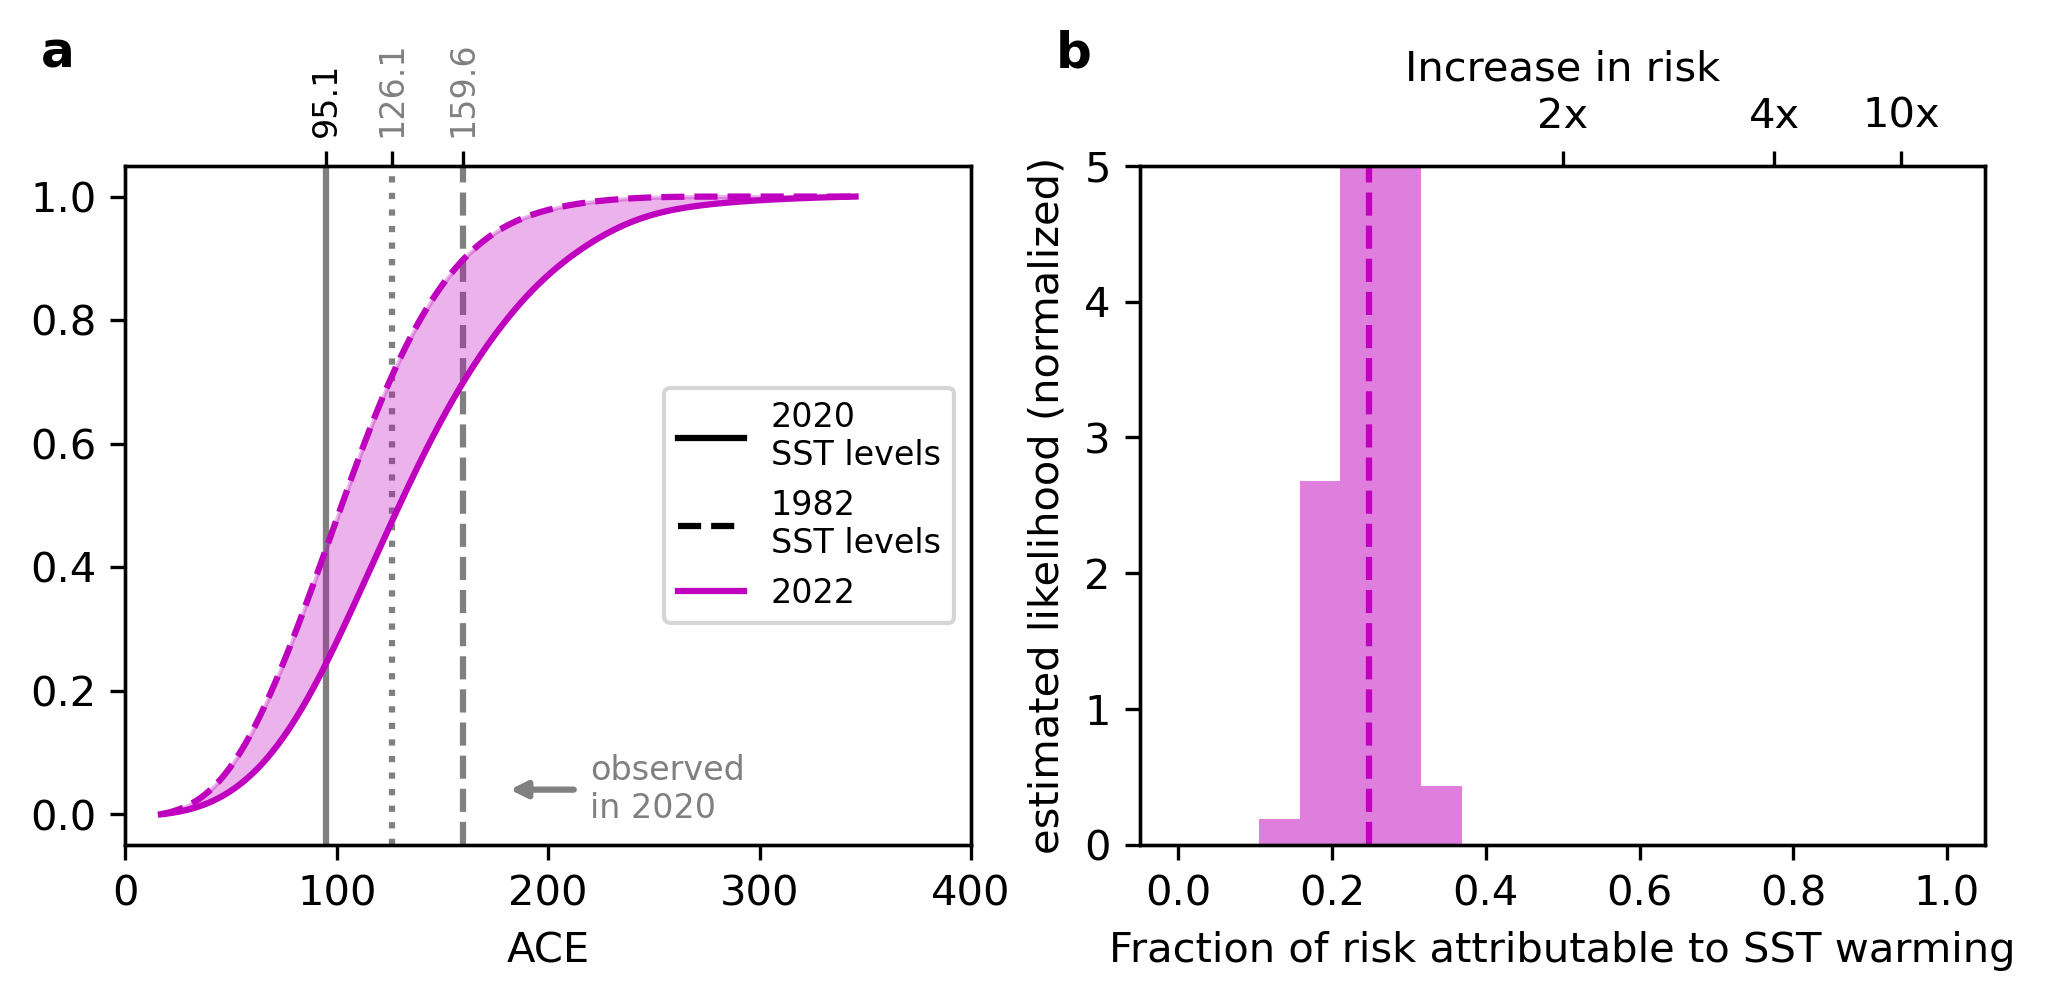

In [25]:
year_groups = {
    #0 : {'years':all_years, 'color':colors[0], 'label':'all years', 'lsty':'-', 'eva':0.5, 'short':'all years'},
    # 1 : {'years':[yr for yr in years if float(counterFacts['2020 SST levels']['ACE'].loc[yr].mean('run').values) >= 126.1], \
    #             'color':'red', 'label':'favorable large scale conditions', 'lsty':'--', 'eva':0.3, 'short':'favorable'},
    #2005 : {'years':[2005], 'color':colors[1], 'label':'2005', 'lsty':'-.', 'eva':0.4},
    #2020 : {'years':[2020], 'color':colors[2], 'label':'2020', 'lsty':'-.', 'eva':0.4},
    2022 : {'years':[2022], 'color':'m', 'label':'2022', 'lsty':'-.', 'eva':0.4},
    #1983 : {'years':[1983], 'color':colors[3], 'label':'1983', 'lsty':'-.', 'eva':0.4},
}
indicator_dict = {
    # 'ACE225' : {'name':'ACE','label':'ACE', 'threshold':225},
    'ACE95' : {'name':'ACE','label':'ACE', 'threshold':95},
    # 'ACE159.6' : {'name':'ACE','label':'ACE', 'threshold':159.6},
    # 'ACE126.1' : {'name':'ACE','label':'ACE', 'threshold':126.1},
    # 'MajHur' : {'name':'MajHur', 'label':'major hurricanes', 'threshold':4.5},
    # 'Hur' : {'name':'Hur','label':'hurricanes', 'threshold':9.2},
}
##################################
# CDFs with difference highlight #
##################################
for ind,indDT in indicator_dict.items():
    indicator = indDT['name']
    threshold = indDT['threshold']
    tmp = np.concatenate([d[indicator].values.flatten() for d in counterFacts.values()])
    X = np.linspace(tmp.min(),tmp.max(),1000)
    bw = (tmp.max() - tmp.min()) / 20

    plt.close()
    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3), dpi=300)
    ax = axes[0]

    for tr,lsty in zip([threshold,126.1,159.6],['-',':','--']):
        ax.axvline(x=tr, color='gray', linestyle=lsty)
        # ax.annotate(tr, xy=(tr, 0), rotation=90, ha='center', va='bottom', fontsize=8, backgroundcolor='w')

    intersects = pd.DataFrame()
    for yrName,yrDT in year_groups.items():
        ys = []
        for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
            DT = counterFacts[scen]
            tmp = DT[indicator][np.isin(DT[indicator].year,yrDT['years'])].values.reshape(-1, 1)
            kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(tmp)
            log_dens = kde.score_samples(X.reshape(-1, 1))
            y = np.exp(log_dens) / np.exp(log_dens).sum()
            ax.plot(X, np.cumsum(y), color=yrDT['color'], linestyle=DT['lsty'], zorder=10)
            ys.append(np.cumsum(y))

        ax.fill_between(X, ys[0], ys[1], color=yrDT['color'], alpha=0.3, zorder=10)

    for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
        DT = counterFacts[scen]
        ax.plot([],[],color='k', linestyle=DT['lsty'], label=DT['label'])

    for yrName,yrDT in year_groups.items():
        ax.plot([],[],color=yrDT['color'], label=yrDT['label'])

    ax.set_xlabel(indDT['label'])
    ax.set_xlim(0,400)
    ax.annotate('observed\nin 2020', xy=(178, 0.04), color='gray', va='center',fontsize=8, 
         xycoords='data',xytext=(220, 0.04), textcoords='data',
         arrowprops=dict(arrowstyle= '-|>',
                         color='gray',lw=1.5,ls='-'))
    ax2 = ax.twiny()
    ax2.set_xlim(0,400)
    ax2.set_xticks([95.1,126.1,159.6])
    ax2.set_xticklabels([95.1,126.1,159.6], rotation=90, ha='center', fontsize=8)
    ax2.get_xticklabels()[1].set_color('gray')
    ax2.get_xticklabels()[2].set_color('gray')
    ax.legend(fontsize=8, loc='center right')

    ax.annotate('a', xy=(-0.1,1.2), xycoords='axes fraction', fontweight='bold', backgroundcolor='w', ha='left', va='top', fontsize=12)
    # plt.savefig(emu._dir+'/'+emu._tag+'/counter_2011-2020/'+indicator+'_cdf_thresh'+str(threshold)+'.png', bbox_inches='tight', dpi=400); plt.close()
    # plt.show()

    ############
    # FAR 2017 #
    ############
    N = 1000
    indicator = indDT['name']
    threshold = indDT['threshold']

    ax=axes[1]

    ref = counterFacts['%s SST levels' %(2020)][indicator]
    for scen in ['%s SST levels' %(yr) for yr in [1982]]:
        DT = counterFacts[scen]
        counter = DT[indicator]
        for yrName,yrDT in year_groups.items():
            yrs = yrDT['years']
            FAR,IR = [],[]
            for i in range(N):
                probRef = np.sum(np.random.choice(ref[np.isin(ref.year,yrs)].values.flatten(), size=int(0.5*N), replace=True) >= threshold) / (0.5*N)
                probCounter = np.sum(np.random.choice(counter[np.isin(counter.year,yrs)].values.flatten(), size=int(0.5*N), replace=True) >= threshold) / (0.5*N)
                FAR.append(1 - probCounter / probRef)
                IR.append(probRef / probCounter)
            if '1982' in scen:
                ax.hist(FAR, bins=np.linspace(0,1,20), density=True, linestyle=DT['lsty'], color=yrDT['color'], alpha=0.5)

            probRef = np.sum(ref[np.isin(ref.year,yrs)].values.flatten() >= threshold) / len(ref[np.isin(ref.year,yrs)].values.flatten())
            probCounter = np.sum(counter[np.isin(ref.year,yrs)].values.flatten() >= threshold) / len(counter[np.isin(ref.year,yrs)].values.flatten())
            FAR = 1 - probCounter / probRef
            print('%s %s FAR %s factor %s' %(ind,yrName, FAR*100, 1/(1-FAR)))
            ax.axvline(x=FAR, linestyle=DT['lsty'], color=yrDT['color'])#, label=yrDT['label'])

#         ax.plot([],[],color='w', label='counterfactual scenario')
#         for scen in ['%s SST levels' %(yr) for yr in [1982]]:
#             DT = counterFacts[scen]
#             ax.plot([],[],color='k', linestyle=DT['lsty'], label=DT['label'])

#         ax.plot([],[],color='w', label='weather conditions')
#         for yrName,yrDT in year_groups.items():
#             ax.plot([],[],color=yrDT['color'], label=yrDT['label'])

    ax.set_xlabel('Fraction of risk attributable to SST warming')
    ax.set_ylabel('estimated likelihood (normalized)')
    ax.set_ylim(0,5)
    ax2 = ax.twiny()
    ax2.set_xticks([0.5,0.75,0.9])
    ax2.set_xticklabels(['%sx' %(i) for i in [2,4,10]])
    ax2.set_xlabel('Increase in risk')
    # ax.legend(fontsize=6, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.annotate('b', xy=(-0.1,1.2), xycoords='axes fraction', fontweight='bold', backgroundcolor='w', ha='left', va='top', fontsize=12)
